# Semester 3 Coding Portfolio Topic 5 Summative:
# Social Network Analysis

In this notebook, you are asked to do original work with little guidance, based on the skills you learned in the formative part (as well as lectures and workshops).
This section is graded not just on passing automated tests, but also on quality, originality, and effort (see assessment criteria in the assignment description).

In [1]:
# TODO: Please enter your student number here
STUDENT_NUMBER = 15854493

# SUMMATIVE ASSESSMENT

For this summative assignment, we ask you to create an agent based model of your choice. You will then run your simulation and visualize and interpret the its behaviour.
Using a dataset is __optional__ for this notebook!

The general assessment criteria for all summative assignments are mentioned in the assignment description on Canvas. Each notebook also has a few specific criteria we look for; make sure you fulfil them in your approach to this assignment.
In general, make sure this notebook represents a complete project: Write an explanation of what you are hoping to achieve with your analysis, document your code well, and present results in a comprehensive way.

## Assessment criteria specific to ABM
 - Clear model specification: Defines the agents, environment, rules, and parameters in a structured manner (e.g., in words or with a simple schematic).
 - Correct implementation of model logic:
 - lements the model without errors or warnings, ensuring that agent interactions follow the described rules.
 - Simulation experiments: Runs the model multiple times or across different parameter settings, generating output suitable for analysis (e.g., time series, distributions, aggregate outcomes).
 - Visualization of model behavior: Presents at least one clear visualization of simulation results.
 - Interpretation of dynamics: Interprets how the model behaves and explains why certain outcomes emerge based on agent rules and interactions, and implications for the phenomenon under study.
 - Sensitivity analysis: Vary at least one key parameter and shows how the system responds (e.g., tipping points, stability, divergence). (Does not require formal statistical testing.)
 - (Optional) Calibration and validation: If relevant, connects the model to real data (e.g., calibrating parameters, or validating against real-world data).

Fot this notebook, use of a dataset is __optional__. If you do decide to use a dataset, please ensure your dataset is a single file under 100MB named sem3_topic6_abm_summative_data.csv or sem3_topic6_abm_summative_data.json.



## DISCLAIMER** 
This is purely an **academic** exercise to learn ABM concepts. I am not making any claims about real people or real criminal behavior. The model treats the network as an abstract structure for studying how influence spreads through highly-connected social systems. So while my topic 5 analysis can draw and be connected to real world context, my topic 6 is different as I create my own rules within a real world environment.

# Agent-Based Model: Influence Spread in the Epstein Network

## Introduction

This notebook builds an Agent-Based Model (ABM) to simulate how influence might spread through a social network. I use the Epstein email network as my environment — a real-world dataset that provides an interesting structure for studying social contagion dynamics.

**Important disclaimer:** This is purely an academic exercise to learn ABM concepts. I am not making any claims about real people or real criminal behavior. The model treats the network as an abstract structure for studying how influence spreads through highly-connected social systems.

## What is ANM?

An ABM simulates a system by defining individual agents that follow simple rules. Complex patterns emerge from these simple interactions. It works just like a flock of birds example from the lecture on ABM with Peter — each bird follows basic rules (stay close to neighbors, don't collide etc), but together they create interesting,, complex patterns.

## MODEL OVERVIEW

**AGENTS** Each person in the email network is an agent (1,114 people total).

**ENVIRONMENT** The social network built from email co-occurrences (who emailed together). Explored in topic 5 in depth, though is initialised in this notebook for the purposes of the assignment to be self-contained

**AGENT STATES**
- **NORMAL (0)** Not yet exposed to influence
- **INFLUENCED (1)** Has been exposed and is susceptible to further change
- **OFFENDER (2)** Has fully adopted the behavior (terminal state)

**TRANSITION RULES**
1. NORMAL -> INFLUENCED: If a normal agent has at least one influenced or offender neighbor, they become influenced with probability `p_normal_to_influenced`
2. INFLUENCED -> OFFENDER: An influenced agent becomes an offender with probability `p_influenced_to_offender` each time step

**INITIAL CONDITIONS** Jeffrey Epstein starts as the sole OFFENDER (he has the highest degree in the network — connected to 991 people).

This follows an SIR-style epidemic model structure (from ABM formative 2), which is a classic approach for modeling how things spread through networks (diseases, information, behaviors)!

## Background

<table>
<tr>
<td style="vertical-align: top; padding-right: 25px;">

<p>
Jeffrey Edward Epstein (January 20, 1953 – August 10, 2019) was an American financier and convicted sex offender. 
He began his professional career as a teacher at the Dalton School. After his dismissal from the school in 1976, 
he entered the banking and finance sector, working at Bear Stearns in various roles before starting his own firm. 
Epstein cultivated an elite social circle and procured many women and girls whom he and his associates sexually abused.
</p>

<p>
Epstein was notorious for maintaining his "elite" connections. Through his friendship with Ghislaine Maxwell he was able 
to befriend the highest classes and most powerful people of the world. He was known for his friendship with Andrew Mountbatten 
(former prince) and Donald Trump (former U.S. president).
</p>

<p>
My interest in looking at Epstein's network was sparked by reading Virginia Giuffre's memoir, 
<i>"Nobody's Girl: A Memoir of Surviving Abuse and Fighting for Justice"</i>. 
Giuffre was one of Epstein's most public victims; tragically, she took her own life in 2025.
</p>

<p>
One of the pictures showcases my gephi visual generated in topic 5, solely for purposes of context
</p>

<p><i>Information was taken from Wikipedia.com</i></p>

</td>

<td style="vertical-align: top;">

<img src="epstein-trump-gmax-melania-6.png" width="600">
<img src="gephi-epstein-6.png" width="1000">

</td>
</tr>
</table>

In [2]:
#import 
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations

## DATASET 

In [3]:
#load the email dataset from JSON file
with open("epstein_emails_dataset.json", encoding="utf-8") as f:
    emails = json.load(f)

print(f"Total emails loaded: {len(emails)}")
print(f"Keys in each email record: {list(emails[0].keys())}")

Total emails loaded: 2322
Keys in each email record: ['source_file', 'subject', 'date', 'participants', 'people_mentioned', 'notable_figures', 'organizations', 'locations', 'summary', 'primary_topic', 'topics', 'tone', 'potential_crimes', 'crime_types', 'mentions_victims', 'victim_names', 'cover_up', 'email_text']


## BUILD THE NETWORK


I build the social network by counting how often pairs of people appear together in emails. If two people frequently appear in the same emails, they have a stronger connection (higher edge weight) -> this is a recreating of how my topic 5 starts

In [4]:
#count how often each pair of people appears together in emails
pair_counter = Counter()
appearances_counter = Counter()

for record in emails:
    #get participants, remove duplicates and empty names
    participants = record.get("participants", [])
    participants = sorted(set(p.strip() for p in participants if p.strip()))
    
    #count individual appearances -> nodes
    for p in participants:
        appearances_counter[p] += 1
    
    #count pair co-occurrences -> edges
    if len(participants) >= 2:
        for a, b in combinations(participants, 2):
            pair_counter[(a, b)] += 1

print(f"Unique participants (nodes): {len(appearances_counter)}")
print(f"Unique participant pairs (edges): {len(pair_counter)}")

Unique participants (nodes): 1119
Unique participant pairs (edges): 7544


In [5]:
#build the network graph
G = nx.Graph()

#add edges with weights based on co-occurrence counts
for (a, b), weight in pair_counter.items():
    G.add_edge(a, b, weight=weight)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 1114
Number of edges: 7544


## EPSTEIN == CENTRAL NODE


I find the most connected person in the network — this will be our "patient zero" who starts as the initial offender And then spreads the "offender" disease

In [6]:
#find the node with the highest degree (most connections)
central_node = max(G.degree(), key=lambda x: x[1])[0]
central_degree = G.degree(central_node)

print(f"Central node: {central_node}")
print(f"Number of connections: {central_degree}")
print(f"This represents {central_degree / G.number_of_nodes() * 100:.1f}% of all people in the network")

Central node: Jeffrey Epstein
Number of connections: 991
This represents 89.0% of all people in the network


**INTERPRIATATION** 


Jeffrey Epstein is connected to roughly 89% of everyone in the network. This "mafia boss" structure means that influence originating from him can spread to almost everyone in just one or two steps. This is a key insight — the network topology will heavily influence how my sim will behave

## MODEL SETUP

In [7]:
# I define agent states 
NORMAL = 0
INFLUENCED = 1
OFFENDER = 2

# NOW i define model parameters
#this can be changed to see different outcomes!
p_normal_to_influenced = 0.15    # probability of becoming influenced when exposed
p_influenced_to_offender = 0.05  # probability of transitioning to offender each step
num_steps = 50                   # how many time steps to run

# final chosen value to 0.5 & 0.3
# test below thershold 0.15 & 0.05
print("Model parameters:")
print(f"  p_normal_to_influenced = {p_normal_to_influenced}")
print(f"  p_influenced_to_offender = {p_influenced_to_offender}")
print(f"  num_steps = {num_steps}")

Model parameters:
  p_normal_to_influenced = 0.15
  p_influenced_to_offender = 0.05
  num_steps = 50


In [8]:
#calc distance from expstein to everyone else
#this tells me how many "hops" away each person is from epstein
distances = nx.single_source_shortest_path_length(G, central_node)

#check how many nodes are reachable
reachable_nodes = len(distances)
total_nodes = G.number_of_nodes()
unreachable_nodes = total_nodes - reachable_nodes

print(f"Nodes reachable from {central_node}: {reachable_nodes}")
print(f"Nodes NOT reachable (disconnected): {unreachable_nodes}")

Nodes reachable from Jeffrey Epstein: 1084
Nodes NOT reachable (disconnected): 30


**INTERPRITATION** 

there are 30 unreachebale . they exist in separate "islands" of the network with no connection path to Epstein. These nodes can never be influenced in my model — they represent people who have no social link whatsoever to the main network component. This is an important structural feature, not a limitation of the model.


This is also consistent with findings in topic 5 where I discovered a separate community with no links to Epstein, which can possible represent help or his pilots, etc; essentially people who would not be in his reach but are connected to him strictly because of his professional affiliations

In [9]:
# initialize all agents as NORMAL
state = {}
for node in G.nodes():
    state[node] = NORMAL

# set the central node (Epstein) as the initial OFFENDER
state[central_node] = OFFENDER

# set his direct neighbors as INFLUENCED (they've been exposed)
for neighbor in G.neighbors(central_node):
    state[neighbor] = INFLUENCED

# count initial states
n_normal = sum(1 for s in state.values() if s == NORMAL)
n_influenced = sum(1 for s in state.values() if s == INFLUENCED)
n_offender = sum(1 for s in state.values() if s == OFFENDER)

print("Initial state distribution:")
print(f"  NORMAL: {n_normal}")
print(f"  INFLUENCED: {n_influenced}")
print(f"  OFFENDER: {n_offender}")

Initial state distribution:
  NORMAL: 122
  INFLUENCED: 991
  OFFENDER: 1


**INTERPRITATION** 

At the start, i have 1 offender (Epstein), ~991 influenced agents (his direct contacts), and ~122 normal agents (people 2+ hops away). Because Epstein is so highly connected, most people are already "exposed" from step 0. This reflects the reality of hub-dominated networks — a central figure has outsized influence.

## RUNNING THE SIM


**MAIN ABM LOOP**
1. Count current states (for tracking)
2. Apply transition rules to each agent
3. Update all states simultaneously (to avoid order effects)

In [10]:
# set up tracking variables
history = {
    'normal': [],
    'influenced': [],
    'offender': []
}

# track distances of new offenders (to see how far influence spreads)
offender_distances = []

In [ ]:
#random seed for reproducibility
np.random.seed(10)

#main sim loop
for step in range(num_steps):
    
    #count current states
    n_normal = sum(1 for s in state.values() if s == NORMAL)
    n_influenced = sum(1 for s in state.values() if s == INFLUENCED)
    n_offender = sum(1 for s in state.values() if s == OFFENDER)
    
    #save to history
    history['normal'].append(n_normal)
    history['influenced'].append(n_influenced)
    history['offender'].append(n_offender)
    
    #print progress every 10 steps
    if step % 10 == 0:
        print(f"Step {step}: Normal={n_normal}, Influenced={n_influenced}, Offender={n_offender}")
    
    #create a copy to store new states (avoids order effects)
    new_state = state.copy()
    
    # apply rules to each agent
    for node in G.nodes():
        
        #RULE 1: NORMAL agents can become INFLUENCED
        #if they have at least one influenced/offender neighbor
        if state[node] == NORMAL:
            for neighbor in G.neighbors(node):
                if state[neighbor] >= INFLUENCED:  # neighbor is influenced or offender
                    if np.random.random() < p_normal_to_influenced:
                        new_state[node] = INFLUENCED
                        break  # only need one successful exposure
        
        #RULE 2: INFLUENCED agents can become OFFENDERS
        elif state[node] == INFLUENCED:
            if np.random.random() < p_influenced_to_offender:
                new_state[node] = OFFENDER
                #track how far this offender is from the central node
                if node in distances:
                    offender_distances.append(distances[node])
    
    #update all states at once
    state = new_state

print(f"\nSimulation complete after {num_steps} steps.")

Step 0: Normal=122, Influenced=991, Offender=1
Step 10: Normal=31, Influenced=609, Offender=474
Step 20: Normal=30, Influenced=332, Offender=752
Step 30: Normal=30, Influenced=198, Offender=886
Step 40: Normal=30, Influenced=106, Offender=978

Simulation complete after 50 steps.


## VISUALS

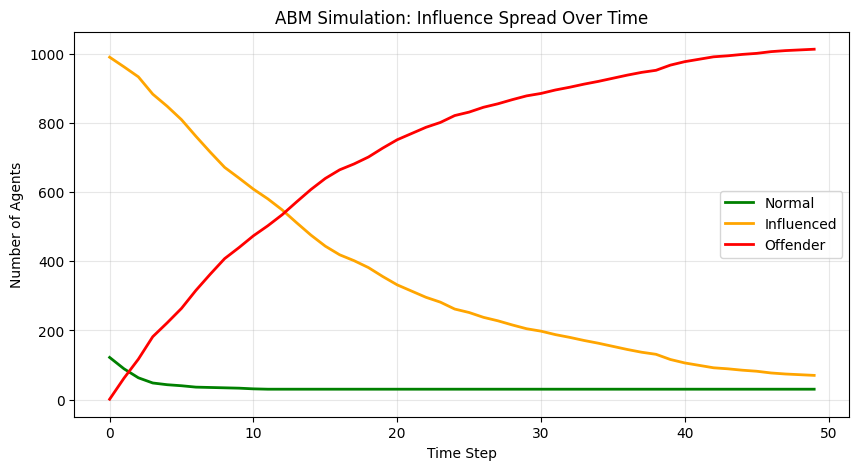

In [12]:
# plot the time series of agent states
plt.figure(figsize=(10, 5))
plt.plot(history['normal'], label='Normal', color='green', linewidth=2)
plt.plot(history['influenced'], label='Influenced', color='orange', linewidth=2)
plt.plot(history['offender'], label='Offender', color='red', linewidth=2)
plt.xlabel('Time Step')
plt.ylabel('Number of Agents')
plt.title('ABM Simulation: Influence Spread Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**INTERPRITATION**

The plot shows a classic "S-curve" pattern typical of epidemic/contagion models (wow beaing a sex-offender is contagious...)

1. **Rapid initial spread (steps 0-5)** The red offender line shoots up quickly. This happens because Epstein is connected to 89% of the network — most people are just one hop away, so influence spreads almost instantly to most of the population.

2. **Transition phase (steps 5-15)** The orange influenced line peaks and then declines as influenced agents transition to offenders. The system is "processing" the initial wave of exposure.

3. **Saturation (steps 20+)** The system reaches equilibrium. Nearly everyone who can be reached has become an offender. The green normal line flattens at a small number — these are the "immune" nodes (the not connected lucky ones)

**MY REASONING** 


The hub-and-spoke network structure means there's no "buffer" to slow the spread. In a more distributed network (like a lattice), influence would spread gradually outward. Here, the highly-connected hub acts like a "superspreader" — everyone gets exposed almost immediately. Which doesn't happen with most viruses, but also in real life viruses don't spread over email

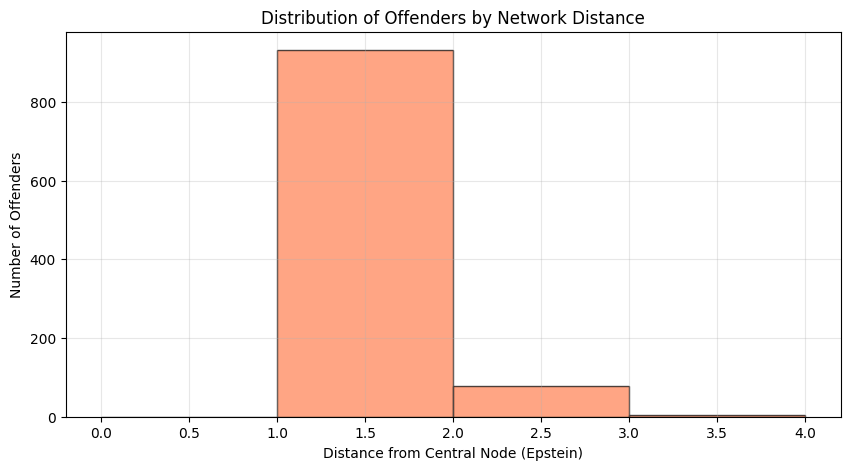

In [13]:
# plot histogram of offender distances from Epstein
plt.figure(figsize=(10, 5))
if offender_distances:
    plt.hist(offender_distances, bins=range(0, max(offender_distances) + 2), 
             edgecolor='black', alpha=0.7, color='coral')
    plt.xlabel('Distance from Central Node (Epstein)')
    plt.ylabel('Number of Offenders')
    plt.title('Distribution of Offenders by Network Distance')
    plt.grid(True, alpha=0.3)
plt.show()

**IINTERPRITATION**

Most offenders are at distance 1 (direct contacts of Epstein). Fewer are at distance 2, and very few at distance 3. This reflects ON

1. **Network structure** Epstein has 991 direct connections, so distance-1 nodes dominate numerically
2. **Spread mechanics** Distance-1 nodes get influenced first (from step 0), so they have more time to transition to offenders
3. **Small-world property** In highly-connected networks, most nodes are only a few hops apart

This pattern is consistent with real-world social contagion — people closest to the "source" are most affected.

## MULTIPLE SIMULATIONS RUN


Running the model once gives us one possible outcome, but randomness means each run could be different. To understand the range of possible outcomes, I run the simulation multiple times with different random seeds.


Even though there is always a possibility for the outcome to be different, I do expect that


1. the 30 immune people will stay like that as their disconnection is inherent to the network topology


2. the influenced and offender to stay fairly similar for the same topology of the network reasons

below i define a function run_simulation with

- random seed for reprodicibility


- and different Ps than my initial set up


so the function will run one complete sim


In [14]:
def run_simulation(seed, p_influence=0.3, p_offender=0.05, steps=20):
    """
    Run one complete simulation and return final counts.
    
    Parameters:
    - seed: random seed for reproducibility
    - p_influence: probability of NORMAL -> INFLUENCED
    - p_offender: probability of INFLUENCED -> OFFENDER
    - steps: number of time steps to run
    
    Returns:
    - tuple of (n_normal, n_influenced, n_offender)
    """
    np.random.seed(seed)
    
    # initialize states
    sim_state = {node: NORMAL for node in G.nodes()}
    sim_state[central_node] = OFFENDER
    
    # run simulation
    for step in range(steps):
        new_state = sim_state.copy()
        
        for node in G.nodes():
            # RULE 1: NORMAL -> INFLUENCED
            if sim_state[node] == NORMAL:
                for neighbor in G.neighbors(node):
                    if sim_state[neighbor] >= INFLUENCED:
                        if np.random.random() < p_influence:
                            new_state[node] = INFLUENCED
                            break
            
            # RULE 2: INFLUENCED -> OFFENDER
            elif sim_state[node] == INFLUENCED:
                if np.random.random() < p_offender:
                    new_state[node] = OFFENDER
        
        sim_state = new_state
    
    # count final states
    n_normal = sum(1 for s in sim_state.values() if s == NORMAL)
    n_influenced = sum(1 for s in sim_state.values() if s == INFLUENCED)
    n_offender = sum(1 for s in sim_state.values() if s == OFFENDER)
    
    return n_normal, n_influenced, n_offender

In [15]:
# run simulation 20 times with different random seeds
num_runs = 20
run_results = []

print("Running multiple simulations...\n")

for seed in range(num_runs):
    n_normal, n_influenced, n_offender = run_simulation(
        seed=seed, 
        p_influence=0.3, 
        p_offender=0.05, 
        steps=20
    )
    run_results.append(n_offender)
    print(f"Seed {seed}: Normal={n_normal}, Influenced={n_influenced}, Offender={n_offender}")

print("\n" + "=" * 50)
print(f"SUMMARY ACROSS {num_runs} RUNS")
print("=" * 50)
print(f"Offenders - Min: {min(run_results)}, Max: {max(run_results)}, Mean: {np.mean(run_results):.1f}")
print(f"Standard deviation: {np.std(run_results):.1f}")

Running multiple simulations...

Seed 0: Normal=30, Influenced=415, Offender=669
Seed 1: Normal=30, Influenced=420, Offender=664
Seed 2: Normal=30, Influenced=433, Offender=651
Seed 3: Normal=30, Influenced=449, Offender=635
Seed 4: Normal=30, Influenced=433, Offender=651
Seed 5: Normal=30, Influenced=460, Offender=624
Seed 6: Normal=30, Influenced=442, Offender=642
Seed 7: Normal=30, Influenced=455, Offender=629
Seed 8: Normal=30, Influenced=444, Offender=640
Seed 9: Normal=30, Influenced=432, Offender=652
Seed 10: Normal=30, Influenced=385, Offender=699
Seed 11: Normal=30, Influenced=433, Offender=651
Seed 12: Normal=31, Influenced=442, Offender=641
Seed 13: Normal=30, Influenced=411, Offender=673
Seed 14: Normal=30, Influenced=440, Offender=644
Seed 15: Normal=31, Influenced=440, Offender=643
Seed 16: Normal=30, Influenced=439, Offender=645
Seed 17: Normal=30, Influenced=456, Offender=628
Seed 18: Normal=30, Influenced=429, Offender=655
Seed 19: Normal=30, Influenced=452, Offender=6

**INTERPRITATIONS**

Running the simulation multiple times shows me the variability in outcomes due to randomness. Key observations are

1. **CONSISTENCY** The results are fairly consistent across runs — the network structure constrains outcomes more than randomness does.

2. **RANGE** The min-max range tells me the best and worst case scenarios under these parameters.

3. **STD** A low standard deviation relative to the mean indicates that the model produces stable, predictable outcomes — not chaotic, highly-variable ones.

This consistency makes sense and is expected as stated before: when i have a hub with 991 connections, the structural properties of the network dominate over random fluctuations.


this would suggest that such ABM analysis essentially is meaningless on the real life example of Epstein network, as the more meningful influences are hiding in the nature of relationships. This can be discovered through perhaps additional nlp analysis of email texts

## SENSITIVITY ANALYSIS


Sensitivity analysis asks **"How robust are my results to my parameter choices?"**

I chose `p_normal_to_influenced = 0.3` somewhat arbitrarily. What if the true value were different? Would my conclusions change dramatically?

Here I vary `p_normal_to_influenced` from 0.05 to 0.9 and observe how the average number of offenders changes.

In [16]:
# sensitivity analysis: vary p_normal_to_influenced
p_values = [0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]
sensitivity_results = []

print("Running sensitivity analysis...\n")

for p in p_values:
    # run 10 simulations for each parameter value
    offender_counts = []
    
    for seed in range(10):
        _, _, n_offender = run_simulation(
            seed=seed, 
            p_influence=p,  # varying this parameter
            p_offender=0.05, 
            steps=20
        )
        offender_counts.append(n_offender)
    
    avg_offenders = np.mean(offender_counts)
    sensitivity_results.append({
        'p': p,
        'avg_offenders': avg_offenders,
        'std': np.std(offender_counts)
    })
    
    print(f"p = {p:.2f}: Average offenders = {avg_offenders:.1f} (±{np.std(offender_counts):.1f})")

Running sensitivity analysis...

p = 0.05: Average offenders = 474.7 (±18.6)
p = 0.10: Average offenders = 569.8 (±18.3)
p = 0.20: Average offenders = 626.5 (±17.2)
p = 0.30: Average offenders = 645.7 (±13.7)
p = 0.50: Average offenders = 661.1 (±14.8)
p = 0.70: Average offenders = 671.1 (±14.4)
p = 0.90: Average offenders = 674.6 (±12.2)


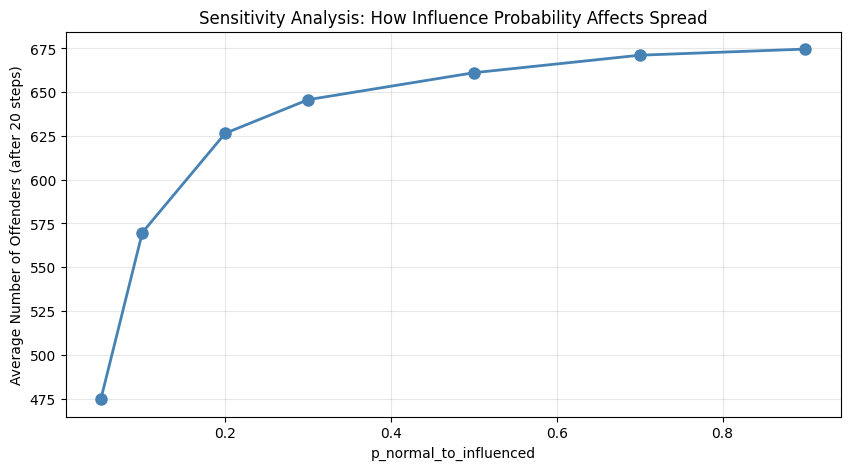

In [17]:
# plot sensitivity analysis results
plt.figure(figsize=(10, 5))
plt.plot([r['p'] for r in sensitivity_results], 
         [r['avg_offenders'] for r in sensitivity_results], 
         marker='o', linewidth=2, markersize=8, color='steelblue')
plt.xlabel('p_normal_to_influenced')
plt.ylabel('Average Number of Offenders (after 20 steps)')
plt.title('Sensitivity Analysis: How Influence Probability Affects Spread')
plt.grid(True, alpha=0.3)
plt.show()

**INTERPRITATION**

The plot reveals a **non-linear, saturating relationship** between the influence probability and the number of offenders:

1. **Steep initial rise (p = 0.05 to 0.3)** Small increases in influence probability lead to large increases in offenders. The system is highly sensitive to the parameter in this range.

2. **Saturation effect (p > 0.3)** Above p = 0.3, the curve flattens. Further increases in influence probability produce diminishing returns — we're hitting a ceiling.

**Why does saturation occur?** The network structure imposes a hard limit. Once p is "high enough" to reach everyone who is reachable, increasing p further can't create new connections. The ~30 disconnected nodes will never be reached regardless of how high p gets.

**Key insight (tipping point)** There appears to be a threshold around p ~ 0.2-0.3 where the system transitions from "partial spread" to "nearly complete spread." Below this threshold, many people escape; above it, nearly everyone reachable becomes an offender. This is a classic feature of contagion on networks.

**Practical implication** If i wanted to prevent spread in a network like this, reducing influence probability below the threshold would be far more effective than reducing it within the saturated region. This has implications for intervention strategies in real-world social contagion scenarios.

## CONCLUSION


This ABM simulation demonstrates several key dynamics of influence spread through a hub-dominated social network:

1. **Hub structure accelerates spread** When a central node is connected to 89% of the network, influence spreads almost instantaneously. There is no gradual "wave" of spread — instead, exposure happens in the first step for most agents.

2. **Network topology creates "natural immunity"** Approximately 30 nodes remain unaffected because they are structurally disconnected from the main component. This is not random resistance but rather the absence of any social pathway for influence to travel.

3. **Threshold dynamics:** The sensitivity analysis reveals a tipping point around p ~ 0.2-0.3. Below this threshold, spread is limited & above it, the system rapidly saturates.

4. **Structural constraints dominate randomness** Multiple runs with different seeds produce consistent results, indicating that network structure is the primary determinant of outcomes, not random chance.

### Limitations

- This is a simplified model — real social influence involves many factors not captured here
- Parameters were chosen for demonstration, not calibrated to real data (and honestly it would highly impossible because of ABM nature)
- The model assumes influence only flows through direct connections (which partly is true however analysis emails in this case is somewhat redundant)

### Academic Note

This exercise demonstrates ABM concepts using a real network structure. No claims are made about real individuals or behaviors. The analysis is purely for learning about social network dynamics and agent-based modeling techniques.